# Abstract

En presente trabajo se analizaron los resultados productivos de una empresa productora de pollos parrilleros para detectar las variables que impactan sobre los resultados y realizar recomendaciones a partir de ello. En segunda instancia se construyó un modelo de predicción de resultados productivos en función de los datos que se suministren en el futuro. 

# Objetivo

El objetivo del presente trabajo es detectar el impacto de los factores que afectan al crecimiento de los pollos parrilleros para tomar decisiones que mejoren los resultados productivos. 

# Contexto comercial

El retorno económico de la empresa productora de pollos parrilleros depende de la obtención de mejores resultados productivos. A mayor ganancia de peso diaria, por ejemplo, el consumo total de alimento será menor disminuyendo el costo. Otro impacto positivo del aumento de la ganancia de peso diaria es que se reduce la edad a faena de los animales ya que se alcanza el peso deseado en menor cantidad de días. Esta reducción de días permite: liberación de superficie de producción (metros cuadrados de galpón, rotación), menor propensión a sufrir enfermedades y accidentes (por ejemplo cortes de luz). También el dueño de la granja tiene menores costos de luz y gas y por lo tanto mayores ganancias finales también.

# Contexto analítico

In [ ]:
# Se presentan las librerías utilizadas:
import pandas as pd
import xlsxwriter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import numpy as np
import datetime
import pingouin as pg
import statsmodels.api as sm
from scipy import stats
import requests
import json

!pip install nbconvert
! pip install -U scikit-learn

! pip install pyppeteer

import plotly.express as px


In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [ ]:
import ydata_profiling

# Data acquisition

La empresa ha provisto un archivo excel con información de resultados y se utilizaron datos climáticos históricos obtenidos a través de una API de Open Meteo.

In [ ]:

#Ingresos semanales compilado registra resultados finales de la producción en la pestaña BASE. Contiene además datos de genética, nutrición y sanidad.
df = pd.read_excel(r"C:\Users\ebover\OneDrive - FRIGORIFICO DE AVES SOYCHU S.A.I.C.F.I.A\ingresos semanales compilado.xlsx",sheet_name='BASE', skiprows=1 , usecols=range(1,67))


In [ ]:
# Se hizo una solicitud HTTP a la API de Open-Meteo
response = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=-32.48&longitude=-58.23&start_date=2020-01-01&end_date=2022-12-31&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=America%2FSao_Paulo')

# Se convirtieron los datos JSON en un diccionario de Python
data = response.json()['daily']

# Se convirtió el diccionario en un DataFrame de pandas
dfc = pd.DataFrame(data)


# Data wrangling

Primero se eliminaron valores erróneos de la base de datos que se conocían antes de iniciar el análisis:

## Base de datos productivos

In [ ]:
df.drop(df[(df['A.D.'] >100)].index, inplace=True) #Elimino valores erróneos
df.drop(df[(df['Edad'] >70)].index, inplace=True) #Elimino edades fuera de estándar

In [ ]:
df.head()

In [ ]:
columns_names = df.columns.values
columns_names
# Los resultados se agrupan por crianza (índice) de cada granja y se registran los diferentes resultados e indicadores de la producción#

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15571 entries, 0 to 15573
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   granja                    15571 non-null  int64         
 1   Primer BB                 15571 non-null  datetime64[ns]
 2   A Faena                   15571 non-null  int64         
 3   % Mortan.                 15571 non-null  float64       
 4   P. Prom.                  15571 non-null  float64       
 5   Ulto. Levan.              15571 non-null  datetime64[ns]
 6   Edad                      15571 non-null  float64       
 7   A.D.                      15571 non-null  float64       
 8   año levante               15571 non-null  int64         
 9   mes levante               15571 non-null  int64         
 10  Tipo de granja            15571 non-null  object        
 11  Estación del año          15571 non-null  object        
 12  Consumo medio diar

In [ ]:
df.shape

La base de datos contiene resultados productivos de 15.571 crianzas desde el año 2015 hasta la primera quincena del mes de abril de 2023.

In [ ]:
df.isna().sum()

Los valores en blanco hallados pertenecen a una columna que no será utilizada en este análisis

In [ ]:
df.duplicated()

La base no posee valores de crianzas duplicados.

## Base de datos climáticos de Concepción del Uruguay, Entre Ríos

In [ ]:
dfc.head()

In [ ]:
columns_names = dfc.columns.values
columns_names

In [ ]:
dfc.shape

In [ ]:
dfc.info()

In [ ]:
dfc.isna().sum()

La base no posee valores en blanco

In [ ]:
dfc.duplicated()

La base no posee fechas duplicadas

De la base de datos provista por la empresa se seleccionarán las siguientes columnas para el análisis:

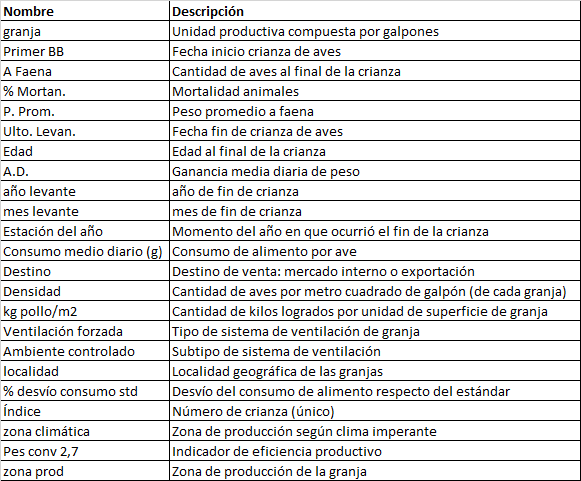


In [ ]:
df=df[['granja','Primer BB','A Faena',
       '% Mortan.','P. Prom.',
       'Ulto. Levan.', 'Edad', 'A.D.',
     'año levante', 'mes levante',
       'Tipo de granja', 'Estación del año',
       'Consumo medio diario (g)', 'Destino',
     'Densidad', 'kg pollo/m2',
    'Ventilación forzada',
       'Ambiente controlado','localidad',
  '% desvío consumo std', 'Índice',
       'zona climática',
   'Pes conv 2,7',
       'zona prod']]

In [ ]:
df.head()

# Análisis exploratorio de datos

In [ ]:
#Data Profiling
profile = pandas_profiling.ProfileReport(df)
profile

In [ ]:
#Histograma de Ganancia media diaria de peso de las 15.571 crianzas de la base#
sns.histplot(data=df, x='A.D.')

In [ ]:
df['A.D.'].describe().round(2)

La **ganancia media diaria de peso** es una medida que permite comparar resultados entre granjas y además permite ver la evolución de los resultados globales de la empresa a lo largo del tiempo. A mayor valor, mejor será el resultado. El valor medio es de **57.18** gramos de peso ganados promedio por día.

In [ ]:
df['Ulto. Levan.'] = pd.to_datetime(df['Ulto. Levan.'])

In [107]:
dfc['time'] = pd.to_datetime(dfc['time'])

In [64]:
df_1=df[['A.D.','año levante']]

In [65]:
df_1['año levante'].astype('object')

0        2015
1        2015
2        2015
3        2015
4        2015
         ... 
15569    2023
15570    2023
15571    2023
15572    2023
15573    2020
Name: año levante, Length: 15571, dtype: object

In [66]:
df_1=df_1[df_1['año levante']]
df_1.tail()

,A.D.,año levante
15569,40.63,2023
15570,57.60,2023
15571,58.82,2023
15572,54.53,2023
15573,61.50,2020


In [85]:
df_1=df_1.groupby('año levante').mean().reset_index().round(2)
df_1

,año levante,A.D.
0,2015,55.65
1,2016,56.45
2,2017,58.12
3,2018,57.92
4,2019,56.99
5,2020,56.76
6,2021,58.44
7,2022,57.82


In [86]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   año levante  8 non-null      int64  
 1   A.D.         8 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 256.0 bytes


In [87]:
  df_1.drop(df_1[(df_1['año levante'] ==2023)].index, inplace=True) 

[Text(0.5, 1.0, 'Ganancia diaria de peso por año')]

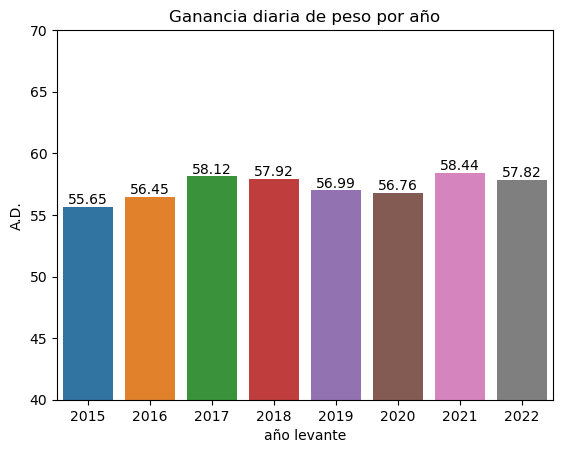

In [88]:
# Gráfico
ax=sns.barplot(data=df_1, x='año levante',y='A.D.') 
ax.bar_label(ax.containers[0])
ax.set(ylim=(40, 70))
ax.set(title='Ganancia diaria de peso por año')

Se observa que las ganancias de peso de los años 2017 y 2021 fueron superiores al resto de los años analizados. El año 2023 fue excluído por estar incompleto.

In [89]:
df_2=df[['A.D.','Estación del año']]
df_2.head()

,A.D.,Estación del año
0,54.49,verano
1,50.63,verano
2,56.12,verano
3,56.12,verano
4,60.98,verano


In [90]:
df_2=df_2.groupby('Estación del año').mean().reset_index().round(2)
df_2

,Estación del año,A.D.
0,invierno,57.99
1,otoño,55.87
2,primavera,59.94
3,verano,55.14


[Text(0.5, 1.0, 'Ganancia diaria de peso por estación del año')]

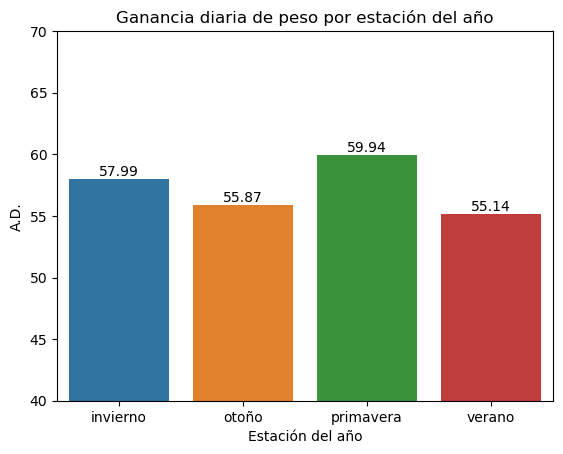

In [91]:
# Gráfico
ax=sns.barplot(data=df_2, x='Estación del año',y='A.D.') 
ax.bar_label(ax.containers[0])
ax.set(ylim=(40, 70))
ax.set(title='Ganancia diaria de peso por estación del año')

Se observa que la ganancia de peso es variable según la estación del año en la que se desarrolle la crianza, las mayores ganancias de peso ocurren en primavera y las peores en verano dando indicios de que el ambiente puede estar afectando el resultado productivo.

In [93]:
df_3=df[['A.D.','mes levante']]
df_3.head()

,A.D.,mes levante
0,54.49,1
1,50.63,1
2,56.12,1
3,56.12,1
4,60.98,1


In [94]:
df_3=df_3.groupby('mes levante').mean().reset_index().round(2)
df_3

,mes levante,A.D.
0,1,55.41
1,2,54.79
2,3,54.84
3,4,55.37
4,5,55.99
5,6,56.43
6,7,57.09
7,8,58.67
8,9,59.53
9,10,60.37


[Text(0.5, 1.0, 'Ganancia diaria de peso por mes del año')]

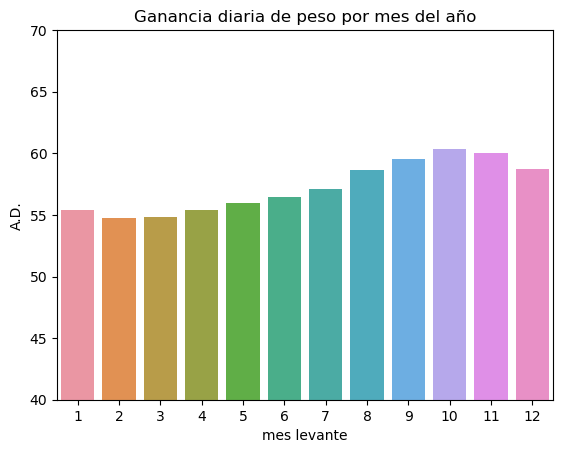

In [97]:
# Gráfico
ax=sns.barplot(data=df_3, x='mes levante',y='A.D.') 
ax.set(ylim=(40, 70))
ax.set(title='Ganancia diaria de peso por mes del año')

Se observan también diferencias en los valores de ganancia media diaria de peso en los meses del año. Debido a ello a continuación se realizará un análisis según los tipos de ventilación que poseen las granjas.

Para ello se han clasificado las granjas en tres categorías:

S: Ventilación forzada: La ventilación del galpón se realiza a través de la entrada del aire por inlets o aberturas en la zona superior de los galpones y su posterior expulsión por extractores.

N: Granjas con sistema de ventilación convencional con encendido manual de ventiladores y/o apertura y cierre de las cortinas laterales del galpón.

MI: Mixtas: Granjas que tienen ambos tipos de galpones.

In [98]:
dfv=df[['Índice','granja','Ulto. Levan.','A Faena','% desvío consumo std','% Mortan.','P. Prom.','Edad','kg pollo/m2','Estación del año','Ventilación forzada','Ambiente controlado','A.D.','Pes conv 2,7','zona prod','mes levante','año levante']]
dfv.head()

,Índice,granja,Ulto. Levan.,A Faena,% desvío consumo std,% Mortan.,P. Prom.,Edad,kg pollo/m2,Estación del año,Ventilación forzada,Ambiente controlado,A.D.,"Pes conv 2,7",zona prod,mes levante,año levante
0,6,2544,2015-01-01,34964,-10.389276,2.88,2.670175,49.0,31.120000,verano,S,N,54.49,1.262878,BA,1,2015
1,7,2558,2015-01-01,54217,-14.867094,5.71,2.679233,52.9,26.410909,verano,N,N,50.63,1.164476,BA,1,2015
2,8,2761,2015-01-01,36483,-1.227077,6.45,2.750870,49.0,24.359223,verano,N,N,56.12,1.194771,BA,1,2015
3,15,2524,2015-01-02,28231,-1.595289,5.90,2.745705,49.0,25.838000,verano,N,N,56.12,1.196094,BA,1,2015
4,21,2741,2015-01-04,38912,3.530095,7.35,3.107525,51.0,31.005128,verano,N,N,60.98,1.265246,BA,1,2015


In [99]:
dfv.set_index('Índice')


,granja,Ulto. Levan.,A Faena,% desvío consumo std,% Mortan.,P. Prom.,Edad,kg pollo/m2,Estación del año,Ventilación forzada,Ambiente controlado,A.D.,"Pes conv 2,7",zona prod,mes levante,año levante
Índice,,,,,,,,,,,,,,,,
6,2544,2015-01-01,34964,-10.389276,2.88,2.670175,49.0,31.120000,verano,S,N,54.49,1.262878,BA,1,2015
7,2558,2015-01-01,54217,-14.867094,5.71,2.679233,52.9,26.410909,verano,N,N,50.63,1.164476,BA,1,2015
8,2761,2015-01-01,36483,-1.227077,6.45,2.750870,49.0,24.359223,verano,N,N,56.12,1.194771,BA,1,2015
15,2524,2015-01-02,28231,-1.595289,5.90,2.745705,49.0,25.838000,verano,N,N,56.12,1.196094,BA,1,2015
21,2741,2015-01-04,38912,3.530095,7.35,3.107525,51.0,31.005128,verano,N,N,60.98,1.265246,BA,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15504,39,2023-04-13,33718,-22.708505,33.10,1.950000,48.0,13.652047,otoño,N,N,40.63,1.018868,ER,4,2023
15516,405,2023-04-13,17634,-12.533778,4.68,2.870000,49.8,28.772727,otoño,N,N,57.60,1.403813,ER,4,2023
15543,2344,2023-04-13,28602,-9.467456,4.66,3.000000,51.0,31.529412,otoño,N,N,58.82,1.391753,ER,4,2023


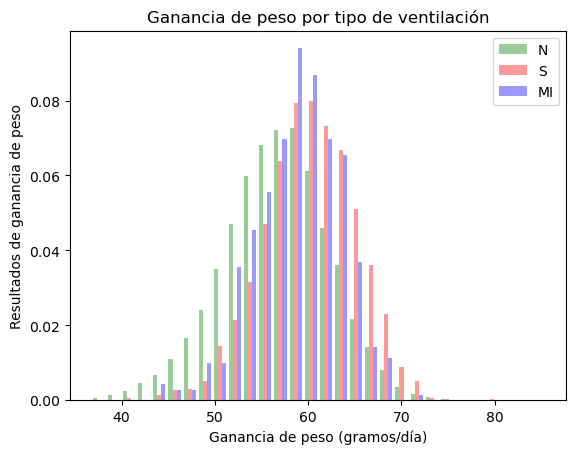

In [100]:
# Datos
serie1 =  dfv.loc[dfv['Ventilación forzada'] == 'N' ,'A.D.']
serie2 =  dfv.loc[dfv['Ventilación forzada'] == 'S' ,'A.D.']
serie3 =  dfv.loc[dfv['Ventilación forzada'] == 'MI' ,'A.D.']

# Crear histograma
plt.hist([serie1, serie2, serie3], bins=30, density= True, color=['green', 'red','blue'], alpha=0.4)

# Personalizar el gráfico
plt.title('Ganancia de peso por tipo de ventilación')
plt.xlabel('Ganancia de peso (gramos/día)')
plt.ylabel('Resultados de ganancia de peso')
plt.legend(['N', 'S','MI'])

# Mostrar el gráfico
plt.show()

En el gráfico se observa que los valores de ganancia de peso de los tres sistemas tienen una distribución normal y que el sistema convencional logra menores ganancias de peso que los sistemas de ventilación forzada y mixto.La distribución de los datos de las granjas convencionales se encuentra desplazada hacia la izquierda, es decir hacia valores menores de ganancia. Su promedio se ubica alrededor de los 56 gramos/días mientras que el promedio de las granjas de ventilación forzada está alrededor de los 60 gramos/día.

In [101]:
dfv_a= dfv.groupby('Ventilación forzada')['A.D.'].mean().reset_index()
dfv_a.set_index('Ventilación forzada')
dfv_a

,Ventilación forzada,A.D.
0,MI,58.863315
1,N,56.731565
2,S,60.130626


[Text(0.5, 1.0, 'Ganancia diaria de peso por sistema de ventilación')]

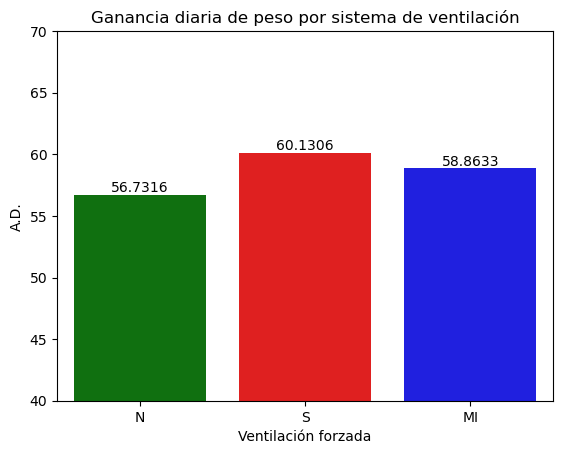

In [102]:
# Gráfico
ax=sns.barplot(data=dfv_a, x='Ventilación forzada',y='A.D.', order=['N','S','MI'], palette=['green', 'red','blue']) 
ax.bar_label(ax.containers[0])
ax.set(ylim=(40, 70))
ax.set(title='Ganancia diaria de peso por sistema de ventilación')

Habría indicios de que el sistema de ventilación tiene impacto sobre la ganancia de peso de los animales.

In [103]:
#Genero un dataframe con los datos filtrados para la localidad de Concepción del Uruguay y fechas para los que se tienen valores de temperaturas
dfCDU_2=df[['Índice','granja','Ulto. Levan.','A Faena','% desvío consumo std','% Mortan.','P. Prom.','Edad','kg pollo/m2','Estación del año','Ventilación forzada','Ambiente controlado','A.D.','Pes conv 2,7','zona prod','mes levante','año levante','zona climática']]

In [105]:
dfCDU_3=dfCDU_2[(dfCDU_2['Ulto. Levan.']>'2019-12-31' ) & (dfCDU_2['Ulto. Levan.']<'2023-04-01')]


In [108]:
#Unifico los dos dataframes generados: datos climáticos y datos productivos de la zona de Concepción del Uruguay en Entre Ríos
df_U=pd.merge(dfc, dfCDU_3, left_on='time', right_on='Ulto. Levan.')
df_U.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,Índice,granja,Ulto. Levan.,A Faena,% desvío consumo std,% Mortan.,...,kg pollo/m2,Estación del año,Ventilación forzada,Ambiente controlado,A.D.,"Pes conv 2,7",zona prod,mes levante,año levante,zona climática
0,2020-01-01,26.1,20.8,0.0,9244,107,2020-01-01,23255,-3.957466,6.23,...,22.817778,verano,N,N,55.25,1.321370,ER,1,2020,otra ER
1,2020-01-01,26.1,20.8,0.0,9245,351,2020-01-01,10368,-7.039973,9.84,...,20.086957,verano,N,N,51.03,1.170520,ER,1,2020,otra ER
2,2020-01-01,26.1,20.8,0.0,9246,405,2020-01-01,10549,34.718920,37.95,...,17.886364,verano,N,N,58.43,0.904018,ER,1,2020,otra ER
3,2020-01-01,26.1,20.8,0.0,9247,1409,2020-01-01,12096,-11.679734,10.40,...,21.913043,verano,N,N,50.11,1.200000,ER,1,2020,otra ER
4,2020-01-01,26.1,20.8,0.0,9248,1837,2020-01-01,44696,-7.923694,5.90,...,32.346325,verano,N,N,57.71,1.345515,ER,1,2020,C. del Uruguay


In [109]:
df_U2=df_U[['año levante','mes levante','temperature_2m_max','A.D.','Ventilación forzada']]
df_U2.head()

,año levante,mes levante,temperature_2m_max,A.D.,Ventilación forzada
0,2020,1,26.1,55.25,N
1,2020,1,26.1,51.03,N
2,2020,1,26.1,58.43,N
3,2020,1,26.1,50.11,N
4,2020,1,26.1,57.71,N


In [110]:
df_U2=df_U2.groupby(['año levante','mes levante','Ventilación forzada']).mean().reset_index()
df_U2.head()

,año levante,mes levante,Ventilación forzada,temperature_2m_max,A.D.
0,2020,1,MI,28.471429,59.065714
1,2020,1,N,28.930573,56.057452
2,2020,1,S,28.877273,60.679545
3,2020,2,MI,30.137500,56.728750
4,2020,2,N,28.905600,54.731760


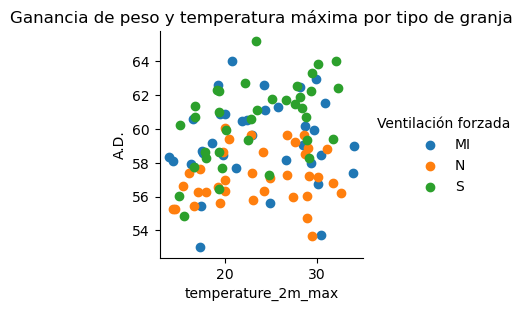

In [117]:
# Gráfico
ax=sns.FacetGrid(df_U2,hue='Ventilación forzada').map(plt.scatter,'temperature_2m_max','A.D.').add_legend()

ax.set(title='Ganancia de peso y temperatura máxima por tipo de granja')

In [122]:
df_U3=df_U[['año levante','mes levante','temperature_2m_min','A.D.','Ventilación forzada']]
df_U3.head()

,año levante,mes levante,temperature_2m_min,A.D.,Ventilación forzada
0,2020,1,20.8,55.25,N
1,2020,1,20.8,51.03,N
2,2020,1,20.8,58.43,N
3,2020,1,20.8,50.11,N
4,2020,1,20.8,57.71,N


In [123]:
df_U3=df_U3.groupby(['año levante','mes levante','Ventilación forzada']).mean().reset_index()
df_U3.head()

,año levante,mes levante,Ventilación forzada,temperature_2m_min,A.D.
0,2020,1,MI,19.828571,59.065714
1,2020,1,N,19.871975,56.057452
2,2020,1,S,19.818182,60.679545
3,2020,2,MI,20.687500,56.728750
4,2020,2,N,18.788000,54.731760


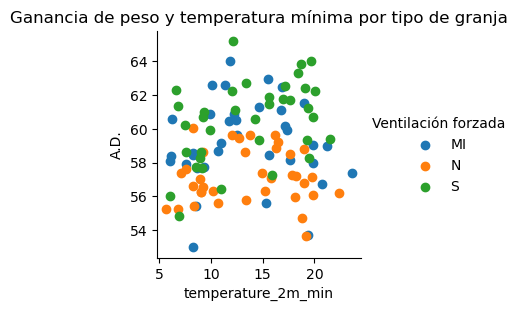

In [124]:
# Gráfico
ax=sns.FacetGrid(df_U3,hue='Ventilación forzada').map(plt.scatter,'temperature_2m_min','A.D.').add_legend()

ax.set(title='Ganancia de peso y temperatura mínima por tipo de granja')

Los gráficos de correlación entre la ganancia de peso y las temperaturas máximas y mínimas diarias no muestran ninguna relación entre estas variables y tampoco en relación al sistema de ventilación.

In [125]:
df_4=df[['A.D.','zona prod']]
df_4.head()

,A.D.,zona prod
0,54.49,BA
1,50.63,BA
2,56.12,BA
3,56.12,BA
4,60.98,BA


In [128]:
df_4=df_4.groupby(['zona prod']).mean().reset_index().round(2)

df_4

,zona prod,A.D.
0,BA,58.63
1,CR,60.43
2,ER,56.43


[Text(0.5, 1.0, 'Ganancia diaria de peso por zona de producción')]

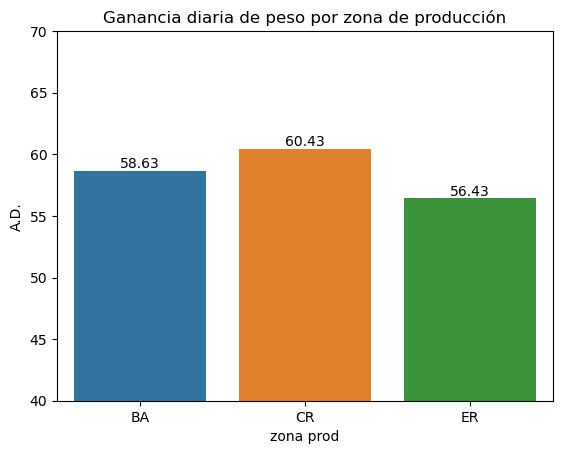

In [129]:
# Gráfico
ax=sns.barplot(data=df_4, x='zona prod',y='A.D.') 
ax.bar_label(ax.containers[0])
ax.set(ylim=(40, 70))
ax.set(title='Ganancia diaria de peso por zona de producción')

A nivel de promedios, hay diferencias entre las zonas del país donde se encuentran ubicadas las granjas.

[Text(0.5, 1.0, 'Ganancia diaria de peso por zona de producción')]

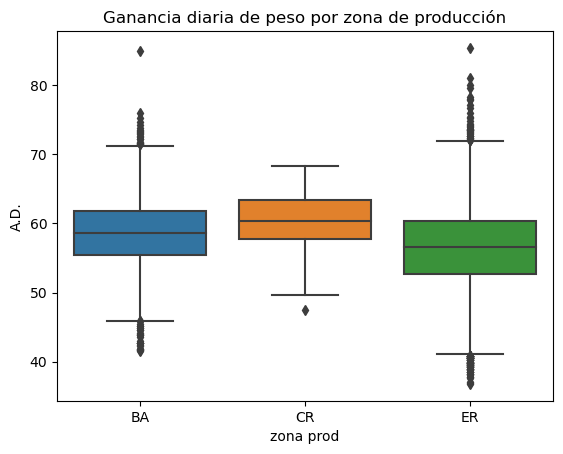

In [136]:
# Gráfico
ax=sns.boxplot(data=df, x='zona prod', y='A.D.') 
ax.set(title='Ganancia diaria de peso por zona de producción')

Los mejores resultados se encuentran en la zona de Crespo (CR), no solo porque tiene mayores valores de ganancia de peso sino también porque los resultados tienen menor dispersión y prácticamente no posee resultados atípicos.

# Machine learning aproximación

In [137]:
df2_num = df.select_dtypes(exclude=object)
df2_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15571 entries, 0 to 15573
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   granja                    15571 non-null  int64         
 1   Primer BB                 15571 non-null  datetime64[ns]
 2   A Faena                   15571 non-null  int64         
 3   % Mortan.                 15571 non-null  float64       
 4   P. Prom.                  15571 non-null  float64       
 5   Ulto. Levan.              15571 non-null  datetime64[ns]
 6   Edad                      15571 non-null  float64       
 7   A.D.                      15571 non-null  float64       
 8   año levante               15571 non-null  int64         
 9   mes levante               15571 non-null  int64         
 10  Consumo medio diario (g)  15571 non-null  float64       
 11  Densidad                  15571 non-null  float64       
 12  kg pollo/m2       

In [138]:
df2_object= df.select_dtypes(include=object)
df2_object.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15571 entries, 0 to 15573
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Tipo de granja       15571 non-null  object
 1   Estación del año     15571 non-null  object
 2   Destino              15571 non-null  object
 3   Ventilación forzada  15571 non-null  object
 4   Ambiente controlado  15571 non-null  object
 5   localidad            15571 non-null  object
 6   zona climática       15571 non-null  object
 7   zona prod            15571 non-null  object
dtypes: object(8)
memory usage: 1.6+ MB


In [173]:
df_5= df[['A.D.', 'año levante','mes levante','Estación del año', 'Ventilación forzada','zona prod']]
df_5.head()

,A.D.,año levante,mes levante,Estación del año,Ventilación forzada,zona prod
0,54.49,2015,1,verano,S,BA
1,50.63,2015,1,verano,N,BA
2,56.12,2015,1,verano,N,BA
3,56.12,2015,1,verano,N,BA
4,60.98,2015,1,verano,N,BA


In [174]:
df5_dummies = pd.get_dummies(df_5)
df5_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15571 entries, 0 to 15573
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   A.D.                        15571 non-null  float64
 1   año levante                 15571 non-null  int64  
 2   mes levante                 15571 non-null  int64  
 3   Estación del año_invierno   15571 non-null  uint8  
 4   Estación del año_otoño      15571 non-null  uint8  
 5   Estación del año_primavera  15571 non-null  uint8  
 6   Estación del año_verano     15571 non-null  uint8  
 7   Ventilación forzada_MI      15571 non-null  uint8  
 8   Ventilación forzada_N       15571 non-null  uint8  
 9   Ventilación forzada_S       15571 non-null  uint8  
 10  zona prod_BA                15571 non-null  uint8  
 11  zona prod_CR                15571 non-null  uint8  
 12  zona prod_ER                15571 non-null  uint8  
dtypes: float64(1), int64(2), uint8(

In [175]:
df5_dummies.head()

,A.D.,año levante,mes levante,Estación del año_invierno,Estación del año_otoño,Estación del año_primavera,Estación del año_verano,Ventilación forzada_MI,Ventilación forzada_N,Ventilación forzada_S,zona prod_BA,zona prod_CR,zona prod_ER
0,54.49,2015,1,0,0,0,1,0,0,1,1,0,0
1,50.63,2015,1,0,0,0,1,0,1,0,1,0,0
2,56.12,2015,1,0,0,0,1,0,1,0,1,0,0
3,56.12,2015,1,0,0,0,1,0,1,0,1,0,0
4,60.98,2015,1,0,0,0,1,0,1,0,1,0,0


In [176]:
# Importar librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [177]:
# Seleccionar las variables predictoras y la variable de destino
X = df5_dummies.drop('A.D.', 1) 
y = df5_dummies['A.D.']

C:\Users\ebover\AppData\Local\Temp\ipykernel_5416\1705318218.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df5_dummies.drop('A.D.', 1)


In [178]:
# Dividir el conjunto de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelo SVR

In [179]:
# Crear el modelo de SVR
model = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [180]:
model.fit(X_train, y_train)

SVR(C=1000.0, gamma=0.1)

In [181]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [182]:
# Calcular el error cuadrático medio (MSE) y el coeficiente de determinación (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [183]:
# Mostrar las métricas de evaluación de rendimiento
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R²):", r2)

Error cuadrático medio (MSE): 25.104881337804418
Coeficiente de determinación (R²): 0.24259967583607478


El modelo aplicado tiene un error cuadrático medio de 25.1 con un coeficiente de determinación del 24.25%. 

## Correlaciones

In [156]:
df5_dummies.corr().round(2)

,A.D.,año levante,mes levante,Estación del año_invierno,Estación del año_otoño,Estación del año_primavera,Estación del año_verano,Ventilación forzada_MI,Ventilación forzada_N,Ventilación forzada_S,zona prod_BA,zona prod_CR,zona prod_ER
A.D.,1.00,0.06,0.32,0.08,-0.13,0.27,-0.22,0.05,-0.19,0.19,0.18,0.06,-0.19
año levante,0.06,1.00,-0.07,-0.02,-0.00,-0.04,0.06,0.09,-0.10,0.07,0.05,0.15,-0.08
mes levante,0.32,-0.07,1.00,0.21,-0.28,0.70,-0.61,0.00,-0.00,0.00,0.00,0.01,-0.01
Estación del año_invierno,0.08,-0.02,0.21,1.00,-0.32,-0.32,-0.35,-0.00,0.00,-0.00,-0.01,-0.00,0.01
Estación del año_otoño,-0.13,-0.00,-0.28,-0.32,1.00,-0.32,-0.34,-0.00,0.01,-0.00,0.00,-0.02,0.00
Estación del año_primavera,0.27,-0.04,0.70,-0.32,-0.32,1.00,-0.34,0.01,-0.01,0.00,0.01,0.01,-0.01
Estación del año_verano,-0.22,0.06,-0.61,-0.35,-0.34,-0.34,1.00,-0.00,-0.00,0.00,0.00,0.01,-0.01
Ventilación forzada_MI,0.05,0.09,0.00,-0.00,-0.00,0.01,-0.00,1.00,-0.41,-0.06,0.07,0.05,-0.08
Ventilación forzada_N,-0.19,-0.10,-0.00,0.00,0.01,-0.01,-0.00,-0.41,1.00,-0.88,-0.09,-0.22,0.13
Ventilación forzada_S,0.19,0.07,0.00,-0.00,-0.00,0.00,0.00,-0.06,-0.88,1.00,0.06,0.22,-0.11


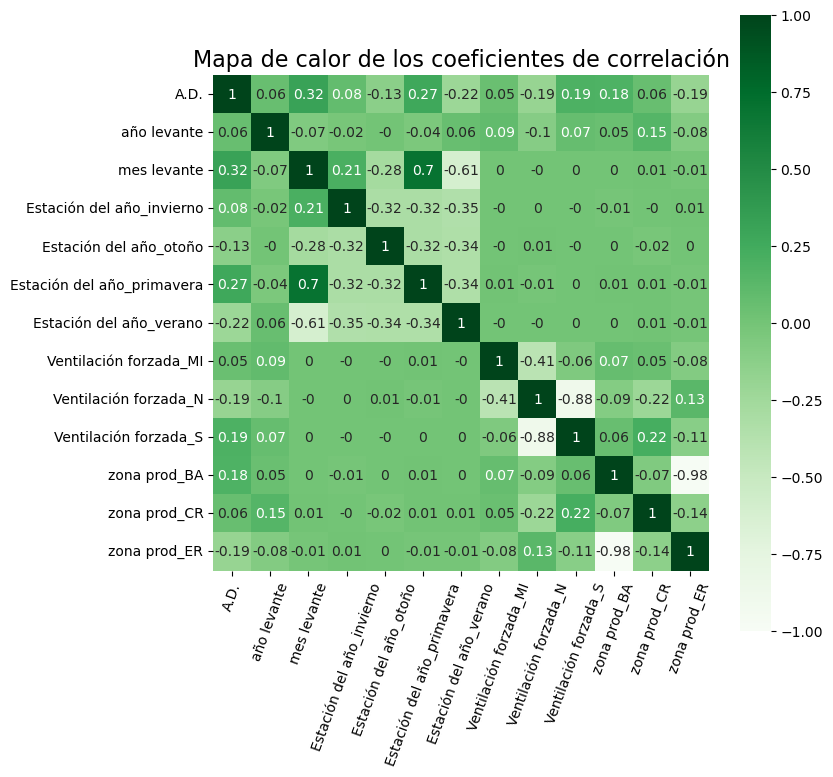

In [185]:
plt.figure(figsize = (8,8))
plt.axis('scaled')
sns.heatmap(df5_dummies.corr().round(2), vmin=-1, vmax=1, cmap = "Greens", cbar = True, annot=True)
plt.xticks(rotation = 70)
plt.title('Mapa de calor de los coeficientes de correlación', fontsize = 16)
plt.show()

Del análisis del mapa de calor se desprende que la correlación entre la ganancia diaria de peso y las variables analizadas es baja en general, siendo los mayores valores un 32% para el mes de levante, un 27% de correlación positiva para la estación del año primavera y un 22% de correlación negativa para la estación verano. 